In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# import torchfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler
from skimage.transform import pyramid_gaussian

In [58]:
!pip install torchfile
import torchfile

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
!ls '/content/gdrive/Team Drives/Deep_learning_course/'

aflw  Ex2_data.tar.gz  fddb  tf_net_fcn.pth  tw_net_fcn.pth  VOCdevkit


In [0]:
home_dir = '/content/gdrive/Team Drives/Deep_learning_course/'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
def evaluate_loss(model, loader, loss_fn):
    """
    evaluate the loss
    """
    batches_loss = []
    for t, (x, y) in enumerate(loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            batches_loss.append(loss.item()) 
    return np.mean(np.array(batches_loss))

  
def evaluate_acu(model, loader):
    acu = []
    for t, (x, y) in enumerate(loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = torch.argmax(model(x), 1)
            acu.append(torch.sum(y_pred == Y_val).item() / y_pred.shape[0])
    return np.mean(np.array(acu))


def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()
  
def save_plot(name, train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.savefig(name)

def train(model, epochs, loader, loss_fn, optimizer, scheduler, val_loader, print_every=10):
    train_loss = []
    val_loss = []
#     train_loss.append(evaluate_loss(model, loader.dataset.tensors[0].to(device=device), loader.dataset.tensors[1].to(device=device), loss_fn))
    val_loss.append(evaluate_loss(model, val_loader, loss_fn))
    train_loss.append(evaluate_loss(model, loader, loss_fn))
    for e in range(1,epochs + 1):
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
        if e % print_every == 0:
            print(f'ephoc {e}, loss = {np.mean(np.array(batches_loss)):.4f}  val_loss = {evaluate_loss(model, val_loader, loss_fn):.4f}')
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, val_loader, loss_fn))
        
    return train_loss, val_loss


import torch.nn as nn
class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [0]:
  def evaluate_acu(model, loader):
    batches_acu = []
    for t, (x, y) in enumerate(loader):
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = torch.argmax(model(x), 1)
            acc = torch.sum(y_pred == y).item() / y_pred.shape[0]
            batches_acu.append(acc)
    return np.mean(np.array(batches_acu))

In [0]:
C = 3
L = 24
W = 24
output_dim = 2

In [0]:
data_dict = torchfile.load(home_dir + 'aflw/aflw_24.t7')

In [0]:
data = []
for key in data_dict:
    data.append(data_dict[key])
data = np.stack(data)

In [68]:
data.shape

(24385, 3, 24, 24)

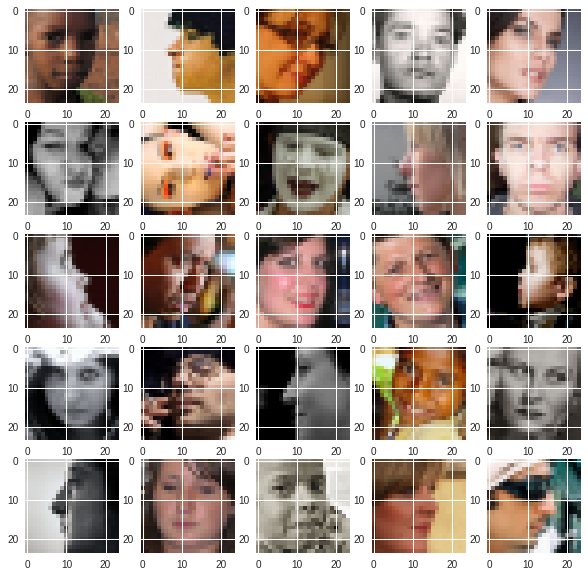

In [69]:
fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, idx in zip(axarr.flatten(), np.random.randint(0, data.shape[0], 25)):
    ax.imshow(np.moveaxis(data[idx], 0, 2))

In [0]:
# data_mean = data.mean(axis = (0,2,3)).reshape(1, 3, 1, 1)
# data_std = data.std(axis = (0,2,3)).reshape(1, 3, 1, 1)
# disp_data = data.copy()
# data -= data_mean
# data /= data_std

In [0]:
person_images_df = pd.read_csv(home_dir + 'VOCdevkit/VOC2007/ImageSets/Main/person_trainval.txt', sep = '\s+', header=None,  dtype={0: str})

In [0]:
person_images_df = person_images_df[person_images_df[1] == -1]

In [73]:
person_images_df.shape

(2916, 2)

In [0]:
num_crop = 5
false_imgs = []
loc_L = 12
loc_W = 12
background_imgs = []
for img_num in person_images_df[0][:30]:
    background_imgs.append(cv2.imread(home_dir + 'VOCdevkit/VOC2007/JPEGImages/%s.jpg' %img_num) / 255)


In [0]:
tw_L = 12
tw_W = 12
conv_12_dim = 16
conv_12_size = 3
conv_12_stride = 1
conv_12_pad = 1
max_pool_size = 3
max_pool_stride = 2
max_pool_pad=1
fc_12_size = 16

val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

In [0]:
tw_net_fcn = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.ZeroPad2d((0, 1, 0, 1)),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=conv_12_dim, out_channels=fc_12_size, kernel_size=(tw_L // 2)),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=fc_12_size, out_channels=output_dim, kernel_size=1),
                           )

In [77]:
tw_net_fcn.load_state_dict(torch.load(home_dir + 'tw_net_fcn.pth'))
tw_net_fcn.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ZeroPad2d(padding=(0, 1, 0, 1), value=0)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(6, 6), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [0]:
def face_rec_12(img, threshold=0.5, iou_threshold=0.5):
#     print(img.shape)
    max_layer = 4
    if min(img.shape[1:]) < 355:
        max_layer = 4
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=max_layer))
    predicted = [tw_net_fcn(torch.FloatTensor(np.moveaxis(pyr.reshape(1, *pyr.shape), 3, 1))) for pyr in pyramid]
    pyramid_sfm = [F.softmax(pred, dim=1) for pred in predicted]
    pyramid_sfm = [pred[0, 1].detach().numpy() for pred in pyramid_sfm]
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,10))  
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
        
    for pred in pyramid_sfm:
        pred[pred < threshold] = 0.0
        
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2)
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
    X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
    iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
    bgier_then_thres = (iou >= iou_threshold)
    iou[bgier_then_thres] = 0.0
    iou[np.logical_not(bgier_then_thres)] = 1.0
    iou[5, 5] = 1.0
    faces = []
    for pred in pyramid_sfm:
        pred = np.pad(pred, (5,5), 'constant')# pad image to allow iou filter multiplication 
        i = 1
        epsilon = 1e-10
        while True:
            ind = np.argsort(pred.flatten())[-i]
            ind = np.unravel_index(ind, pred.shape)
            if pred[ind] < epsilon:
                break
            k, l = ind[0], ind[1]
            pred[k-5: k + 6, l - 5: l + 6] *= iou
            i += 1
        faces.append(pred[5:-5, 5:-5]) # cutting off the padding
#     for fc in faces:
#         plt.figure()
#         plt.imshow(fc)
#         plt.colorbar()
#         plt.title(fc.shape)
    return faces

def extract_fddb_format(img_pyramid_hm, img_name, fc_size=12):
    imgs_det = []
    for i, hm in enumerate(img_pyramid_hm):
        r = (2 ** i + 1) * fc_size
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)
        for k, l in inds:
            imgs_det.append(f'{rr} {rr} 0 {k * 2 * (2 ** i) + (r / 2)} {l * 2 * (2 ** i) + (r / 2)} {hm[k, l]}')
    return f'{img_name}{len(imgs_det)}\n' + "\n".join(imgs_det)

def drow_ff(img, threshold=0.9, iou_threshold=0.1):
    import matplotlib.patches as patches
    img_pyramid_hm = face_rec_12(img, threshold=threshold, iou_threshold=iou_threshold)
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=4))
    rectangels = []
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(np.moveaxis(img, 0, 2))
    num_of_rec = 0
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        print(hm.shape)
        r = (2 ** i + 1) * 12
        e = (2 ** i + 1) * 12 // 2
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)
        num_of_rec += inds.shape[0]
        j = 0
        for k, l in inds:
            j += 1
#             print(j, i, k, l, (k * 2 * (2 ** (i))), (l * 2 * (2 ** (i))), rr)
            ellipse = patches.Ellipse((l * 2 * (2 ** i) + e, k * 2 * (2 ** i) + e), rr , rr * 1.2, 0, edgecolor='g', facecolor='none')
            rect = patches.Rectangle((l * 2 * (2 ** (i)), k * 2 * (2 ** (i))), r, r, edgecolor='r', facecolor='none')
            ax.add_patch(rect)     
            ax.add_patch(ellipse)
#             plt.imshow(pyramid[i][2 * k: 2 * k + 12, 2 * l: 2 * l + 12])
#             plt.show()
#             if j == 5:
#                 break
        fig.show()
    print(num_of_rec)
    
def extract_false_imgs(imgs, threshold=0.95, iou_threshold=0.5):
  false_imgs = []
  for j, img in enumerate(imgs):
    img_pyramid_hm = face_rec_12(np.moveaxis(img, 2, 0), threshold=threshold, iou_threshold=iou_threshold)
    pyramid = tuple(pyramid_gaussian(img, downscale=2, max_layer=4))
    for v, hm in enumerate(img_pyramid_hm[1:]):
      i = v + 1
      inds = np.argwhere(hm > 1e-10)
      for k, l in inds:
        false_imgs.append(np.moveaxis(cv2.resize(pyramid[i][k * 2: k * 2 + 12, l * 2: l * 2 + 12], dsize=(24, 24), interpolation=cv2.INTER_NEAREST), 2, 0))
  return np.stack(false_imgs)

In [0]:
false_imgs = extract_false_imgs(background_imgs, 0.9, 0.2)

In [80]:
false_imgs.shape

(7784, 3, 24, 24)

(89, 120)


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(42, 57)
(18, 26)
(7, 11)
359


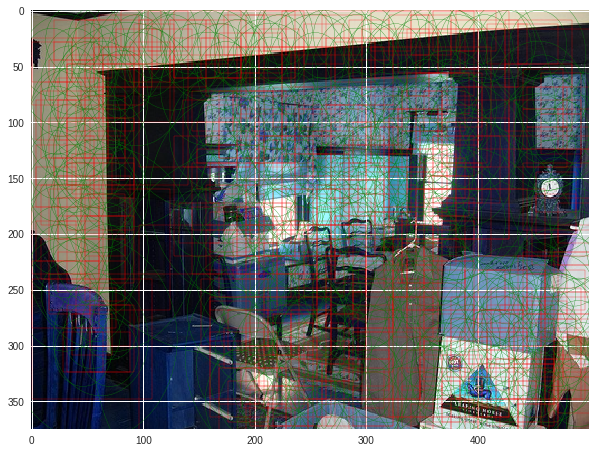

In [81]:
drow_ff(np.moveaxis(background_imgs[0], 2, 0), 0.8, 0.2)

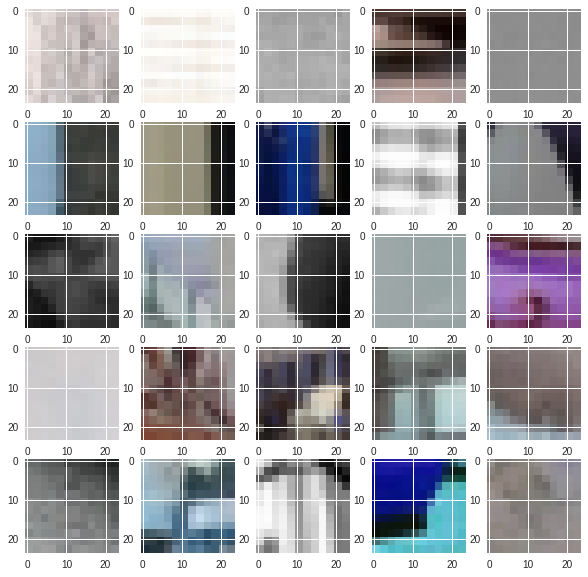

In [82]:
fig, axarr = plt.subplots(5, 5, figsize=(10, 10))
for ax, idx in zip(axarr.flatten(), np.random.randint(0, false_imgs.shape[0], 25)):
    ax.imshow(np.moveaxis(false_imgs[idx], 0, 2))

In [0]:
false_imgs = false_imgs.astype(np.float64)
# false_imgs_mean = false_imgs.mean(axis = (0,2,3)).reshape(1, 3, 1, 1)
# false_image_std = false_imgs.std(axis = (0,2,3)).reshape(1, 3, 1, 1)
# dis_false_imgs = false_imgs.copy()
# false_imgs -= false_imgs_mean
# false_imgs /= false_image_std

In [84]:
X = np.concatenate((data, false_imgs))
Y = np.concatenate((np.ones(data.shape[0]), np.zeros(false_imgs.shape[0])))
X.shape, Y.shape

((32169, 3, 24, 24), (32169,))

In [0]:
conv_24_dim = 64
conv_24_size = 5
conv_24_stride = 1
conv_24_pad = 2
max_pool_size = 3
max_pool_stride = 2
max_pool_pad=1
fc_24_size = 128

val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

In [86]:
torch.cuda.current_device()

0

In [0]:
tf_net_fcn = nn.Sequential(nn.Conv2d(C, conv_24_dim, conv_24_size, padding=conv_24_pad),
                           nn.ZeroPad2d((0, 1, 0, 1)),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=conv_24_dim, out_channels=fc_24_size, kernel_size=(L // 2)),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=fc_24_size, out_channels=output_dim, kernel_size=1),
                           ).to(device)

In [0]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask])
X_train = torch.FloatTensor(X[train_mask])
Y_val = torch.LongTensor(Y[val_mask]).view(-1, 1, 1)
Y_train = torch.LongTensor(Y[train_mask]).view(-1, 1, 1)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))
loader_val = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [0]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tf_net_fcn.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [90]:
loss = train(tf_net_fcn, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, loader_val)

ephoc 10, loss = 0.0027  val_loss = 0.0027
ephoc 20, loss = 0.0013  val_loss = 0.0012
ephoc 30, loss = 0.0030  val_loss = 0.0316


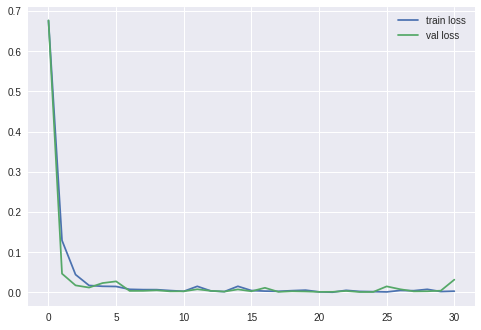

In [91]:
plt.plot(np.arange(len(loss[0])), loss[0], label='train loss')
plt.plot(np.arange(len(loss[1])), loss[1], label='val loss')
plt.legend()

In [0]:
a = tw_net_fcn(X_val)

In [93]:
a.shape

torch.Size([4825, 2, 7, 7])

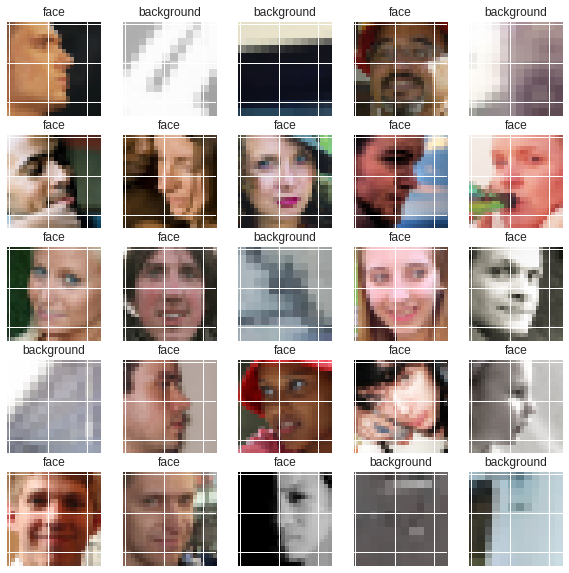

In [94]:
y_pred = None
try:
  y_pred = torch.argmax(tf_net_fcn(X_val.to(device)), 1)
except Exception as e:
  print(str(e))
fig, axarr = plt.subplots(5, 5, figsize=(10,10))
d = []
for ax, idx in zip(axarr.flatten(), np.random.randint(0, X_val.shape[0], 25)):
    if y_pred[idx] == 0:
        title = 'background'
        
    else:
        title = 'face'
        
    disp = X_val.numpy()[idx]
    ax.imshow(np.moveaxis(disp, 0, 2))
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [97]:
evaluate_acu(tf_net_fcn, loader_val)

0.9930098684210527

In [0]:
torch.save(tf_net_fcn.state_dict(), home_dir + 'tf_net_fcn.pth')

In [0]:
with open(home_dir + 'fddb/FDDB-folds/FDDB-fold-01.txt') as f:
    paths = f.readlines()
imgs = []
for path in paths:
    img = cv2.imread(home_dir + 'fddb/images/' + path[:-1] + '.jpg')
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float64) / 255
#     img -= img.mean(axis=(0,1)).reshape(1, 1, 3)
#     img /= img.std(axis=(0,1)).reshape(1, 1, 3)
    img_t = img.copy()
    img_t[:, :, 0] = img[:, :, 2]
    img_t[:, :, 2] = img[:, :, 0]
    imgs.append(np.moveaxis(img_t, 2, 0))

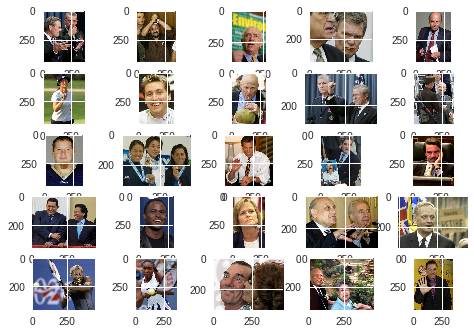

In [137]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, len(imgs), 25)):
    ax.imshow(np.moveaxis(imgs[idx], 0, 2))

In [0]:
def face_rec_12(img, threshold=0.5, iou_threshold=0.5):
#     print(img.shape)
    max_layer = 4
    if min(img.shape[1:]) < 355:
        max_layer = 4
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=max_layer))
    predicted = [tw_net_fcn(torch.FloatTensor(np.moveaxis(pyr.reshape(1, *pyr.shape), 3, 1))) for pyr in pyramid]
    pyramid_sfm = [F.softmax(pred, dim=1) for pred in predicted]
    pyramid_sfm = [pred[0, 1].detach().numpy() for pred in pyramid_sfm]
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,10))  
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
        
    for pred in pyramid_sfm:
        pred[pred < threshold] = 0.0
        
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2)
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
    X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
    iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
    bgier_then_thres = (iou >= iou_threshold)
    iou[bgier_then_thres] = 0.0
    iou[np.logical_not(bgier_then_thres)] = 1.0
    iou[5, 5] = 1.0
    faces = []
    for pred in pyramid_sfm:
        pred = np.pad(pred, (5,5), 'constant')# pad image to allow iou filter multiplication 
        i = 1
        epsilon = 1e-10
        while True:
            ind = np.argsort(pred.flatten())[-i]
            ind = np.unravel_index(ind, pred.shape)
            if pred[ind] < epsilon:
                break
            k, l = ind[0], ind[1]
            pred[k-5: k + 6, l - 5: l + 6] *= iou
            i += 1
        faces.append(pred[5:-5, 5:-5]) # cutting off the padding
#     for fc in faces:
#         plt.figure()
#         plt.imshow(fc)
#         plt.colorbar()
#         plt.title(fc.shape)
    return faces

def extract_fddb_format(img_pyramid_hm, img_name, fc_size=12):
    imgs_det = []
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        r = (2 ** i + 1) * fc_size
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)

        for k, l in inds:
            imgs_det.append(f'{r} {r * 1.2} 0 {k * 2 * (2 ** i) + (r / 2)} {l * 2 * (2 ** i) + (r / 2)} {hm[k, l]}')
    return f'{img_name}{len(imgs_det)}\n' + "\n".join(imgs_det)

def drow_ff(img, threshold=0.9, iou_threshold=0.1):
    import matplotlib.patches as patches
    img_pyramid_hm = face_rec_12(img, threshold=threshold, iou_threshold=iou_threshold)
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=4))
    rectangels = []
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(np.moveaxis(img, 0, 2))
    num_of_rec = 0
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        print(hm.shape)
        r = (2 ** i + 1) * 12
        e = (2 ** i + 1) * 12 // 2
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)
        num_of_rec += inds.shape[0]
        j = 0
        for k, l in inds:
            j += 1
#             print(j, i, k, l, (k * 2 * (2 ** (i))), (l * 2 * (2 ** (i))), rr)
            ellipse = patches.Ellipse((l * 2 * (2 ** i) + e, k * 2 * (2 ** i) + e), rr , rr * 1.2, 0, edgecolor='g', facecolor='none', linewidth=2.0)
            rect = patches.Rectangle((l * 2 * (2 ** (i)), k * 2 * (2 ** (i))), r, r, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)     
            ax.add_patch(ellipse)
#             plt.imshow(pyramid[i][2 * k: 2 * k + 12, 2 * l: 2 * l + 12])
#             plt.show()
            if j == 5:
                break
        fig.show()
    print(num_of_rec)

(107, 94)
(51, 44)
(23, 20)
(9, 7)
283


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


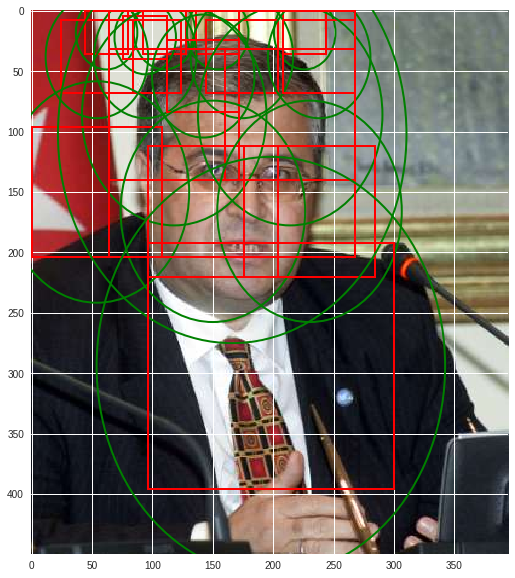

In [161]:
idx = 56
drow_ff(imgs[idx], 0.9, 0.2)

In [0]:
def face_rec(img, threshold=0.5, iou_threshold=0.5, tf_threshold=0.5):
#     print(img.shape)
    max_layer = 4
    if min(img.shape[1:]) < 355:
        max_layer = 4
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=max_layer))
    predicted = [tw_net_fcn(torch.FloatTensor(np.moveaxis(pyr.reshape(1, *pyr.shape), 3, 1))) for pyr in pyramid]
    pyramid_sfm = [F.softmax(pred, dim=1) for pred in predicted]
    pyramid_sfm = [pred[0, 1].detach().numpy() for pred in pyramid_sfm]
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,10))  
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
        
    for pred in pyramid_sfm:
        pred[pred < threshold] = 0.0
        
#     for pred, pyr in zip(pyramid_sfm, pyramid):
#         fig, (ax0, ax1) = plt.subplots(ncols=2)
#         ax0.imshow(pyr)
#         ax1.imshow(pred)
# #         fig.colorbar(plt.pcolor(pred), ax=ax1)
#         plt.show()
    
    X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
    iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
    bgier_then_thres = (iou >= iou_threshold)
    iou[bgier_then_thres] = 0.0
    iou[np.logical_not(bgier_then_thres)] = 1.0
    iou[5, 5] = 1.0
    faces = []
    for j, pred in enumerate(pyramid_sfm):
        pred = np.pad(pred, (5,5), 'constant')# pad image to allow iou filter multiplication 
        i = 1
        epsilon = 1e-10
        while True:
            ind = np.argsort(pred.flatten())[-i]
            ind = np.unravel_index(ind, pred.shape)
            if pred[ind] < epsilon:
                break
            k, l = ind[0], ind[1]
            crop_img = pyramid[j][k * 2: k * 2 + 12, l * 2: l * 2 + 12]
#             plt.figure()
#             plt.imshow(crop_img)
            rescale_face = cv2.resize(crop_img, dsize=(24, 24), interpolation=cv2.INTER_NEAREST)
#             plt.figure()
#             plt.imshow(rescale_face)
            rescale_face = torch.FloatTensor(np.moveaxis(rescale_face.reshape(1, *rescale_face.shape), 3, 1)).to(device)
#             print(rescale_face.shape)
            y_24 = tf_net_fcn(rescale_face)
#             print(y_24.shape)
            face_prob = F.softmax(y_24, 1).view(-1)
#             print(face_prob)
#             break
            if face_prob[1] < tf_threshold:
                pred[k, l] = 0.0
                continue
            pred[k-5: k + 6, l - 5: l + 6] *= iou
            i += 1
        faces.append(pred[5:-5, 5:-5]) # cutting off the padding
#     for fc in faces:
#         plt.figure()
#         plt.imshow(fc)
#         plt.colorbar()
#         plt.title(fc.shape)
    return faces

def extract_fddb_format(img_pyramid_hm, img_name, fc_size=12):
    imgs_det = []
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        r = (2 ** i + 1) * fc_size
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)

        for k, l in inds:
            imgs_det.append(f'{r} {r * 1.2} 0 {k * 2 * (2 ** i) + (r / 2)} {l * 2 * (2 ** i) + (r / 2)} {hm[k, l]}')
    return f'{img_name}{len(imgs_det)}\n' + "\n".join(imgs_det)

def drow_ff_24(img, threshold=0.9, iou_threshold=0.1, tf_threshold=0.5):
    import matplotlib.patches as patches
    img_pyramid_hm = face_rec(img, threshold=threshold, iou_threshold=iou_threshold, tf_threshold=tf_threshold)
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, max_layer=4))
    rectangels = []
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(np.moveaxis(img, 0, 2))
    num_of_rec = 0
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        print(hm.shape)
        r = (2 ** i + 1) * 12
        e = (2 ** i + 1) * 12 // 2
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)
        num_of_rec += inds.shape[0]
        j = 0
        for k, l in inds:
            j += 1
#             print(j, i, k, l, (k * 2 * (2 ** (i))), (l * 2 * (2 ** (i))), rr)
            ellipse = patches.Ellipse((l * 2 * (2 ** i) + e, k * 2 * (2 ** i) + e), rr , rr * 1.2, 0, edgecolor='g', facecolor='none', linewidth=1.0)
            rect = patches.Rectangle((l * 2 * (2 ** (i)), k * 2 * (2 ** (i))), r, r, edgecolor='r', facecolor='none', linewidth=1.0)
            ax.add_patch(rect)     
            ax.add_patch(ellipse)
#             plt.imshow(pyramid[i][2 * k: 2 * k + 12, 2 * l: 2 * l + 12])
#             plt.show()
            if j == 5:
                break
        fig.show()
    print(num_of_rec)

(107, 94)
(51, 44)
(23, 20)
(9, 7)
52


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


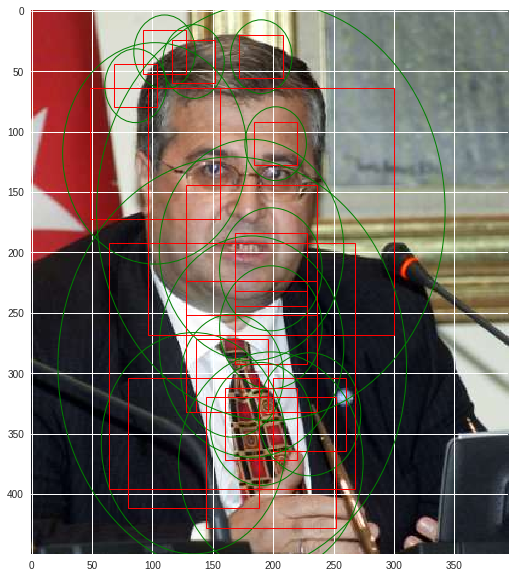

In [162]:
idx = 56
drow_ff_24(imgs[idx], 0.9, 0.2, 0.5)